# Analysis of thermistor calibration

In [22]:
import sys
sys.path.append('../')

from SteinhartHart import SteinHart

import matplotlib
%matplotlib inline

import pandas as pd
import numpy as np 

In [11]:
##################################
#       Hyperparameters
##################################
min_temp = 10
max_temp = 40
avg_temp = 25

fluctuation = 0.5
precision_adc = 10

In [14]:
print("minium precision:", round((max_temp - min_temp)/(2**precision_adc), 3), "degrees")

minium precision: 0.029 degrees


## Retrieve the data

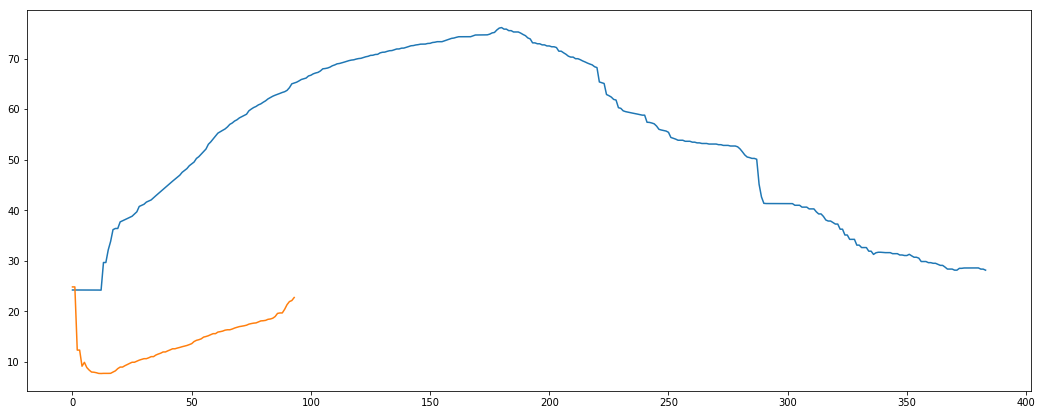

In [15]:
df_cold = pd.read_csv('../data/rev_csv_2018-11-27_10-35.csv')
df_hot = pd.read_csv('../data/rev_csv_2018-11-27_11-02.csv')

df_hot['Tprobe'].plot(figsize=(18, 7))
df_cold['Tprobe'].plot(figsize=(18, 7))

In [32]:
df_hot[df_hot["Tprobe"] <= 40.0]

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
0,0,47457.128906,24.18066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,47457.128906,24.18066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,47457.128906,24.18085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,47457.128906,24.18085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,47457.128906,24.18085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,47457.128906,24.18085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,47457.128906,24.18079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,47457.128906,24.18079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,47457.128906,24.18079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,47457.128906,24.18079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Query the min max and average temperature to calculate the coefficients

In [16]:
df_cold.query(" Tprobe < " + str(min_temp) + " + " + str(fluctuation) + " and Tprobe > " + str(min_temp) + " - " + str(fluctuation))

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
5,5,92633.429395,9.859467,9.555594,-0.006903,0.001273,-0.000003,9.088684,95519.558824,12.28146,78797.142857,24.78897,45995.480769
24,24,95519.558824,9.654785,8.856749,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769
25,25,94682.894737,9.873291,9.002135,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769
26,26,94268.221574,9.873291,9.075063,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769
27,27,93446.086957,10.084290,9.221389,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769
28,28,93038.583815,10.290920,9.294787,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769
29,29,92230.603448,10.441350,9.442055,-0.005254,0.001048,-0.000002,7.646210,103049.535604,12.28146,78797.142857,24.78897,45995.480769


In [17]:
df_hot.query(" Tprobe < " + str(max_temp) + " + " + str(fluctuation) + " and Tprobe > " + str(max_temp) + " - " + str(fluctuation))

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
27,27,26264.339909,39.66162,39.661620,-0.002371,0.000670,-1.185281e-06,24.16681,47643.052838,29.62064,37939.718805,39.66162,26264.339909
309,309,23050.362845,40.23434,39.756695,-0.000756,0.000467,-7.253362e-07,24.16681,47643.052838,50.23169,15378.395860,76.13272,6800.446927
310,310,23255.895197,40.23434,39.542279,-0.000756,0.000467,-7.253362e-07,24.16681,47643.052838,50.23169,15378.395860,76.13272,6800.446927
311,311,23359.110787,40.23434,39.435551,-0.000756,0.000467,-7.253362e-07,24.16681,47643.052838,50.23169,15378.395860,76.13272,6800.446927
312,312,24090.132548,39.65683,38.697216,-0.000756,0.000467,-7.253362e-07,24.16681,47643.052838,50.23169,15378.395860,76.13272,6800.446927


In [18]:
df_cold.query(" Tprobe < " + str(avg_temp) + " + " + str(fluctuation) + " and Tprobe > " + str(avg_temp) + " - " + str(fluctuation))

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
0,0,45995.480769,24.78897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,45995.480769,24.78897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
steinhart = SteinHart()
steinhart.feed(T=9.859467, R=92633.429395)
steinhart.feed(T=24.78897, R=45995.480769)
steinhart.feed(T=40.23434, R=23050.362845)

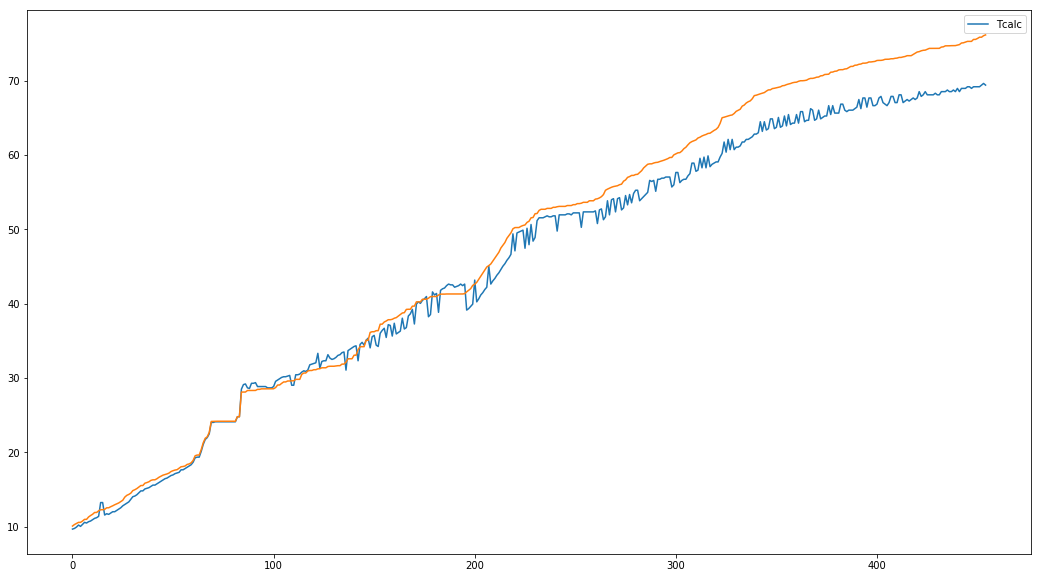

In [41]:
df_pred = df_cold[df_cold['Tprobe'] >= 10.0]
df_pred = df_pred.append(df_hot[df_hot['Tprobe'] <= 80.0], ignore_index=True)
df_pred = df_pred.sort_values('Tprobe').reset_index()

df_pred['Tcalc'] = df_pred.apply(lambda r: steinhart.calculateT(r["RNTC"]), axis=1)
df_pred['Tcalc'].plot(figsize=(18, 10), legend=True)
df_pred['Tprobe'].plot()